In [2]:

import pandas as pd
import re
from collections import defaultdict, Counter
import spacy
import glob
import string
from spacy.matcher import Matcher 
from spacy.training import Example
import os
import sys
import numpy as np
from pathlib import Path
import nltk
from rake_nltk import Rake
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from sklearn_crfsuite import CRF,metrics
import spacy
from collections import defaultdict, Counter
import networkx as nx
from spacy.matcher import PhraseMatcher
from collections import defaultdict
from tqdm.auto import tqdm
import string
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem  import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
folder_path = "C:/Users/amber/Downloads/archive/"
libros = {}
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
            libros[filename] = f.read()
for nombre, texto in libros.items():
    print(f"{nombre}: {len(texto)} caracteres")


01 Harry Potter and the Sorcerers Stone.txt: 439516 caracteres
02 Harry Potter and the Chamber of Secrets.txt: 492336 caracteres
03 Harry Potter and the Prisoner of Azkaban.txt: 625764 caracteres
04 Harry Potter and the Goblet of Fire.txt: 1100552 caracteres
05 Harry Potter and the Order of the Phoenix.txt: 1499693 caracteres
06 Harry Potter and the Half-Blood Prince.txt: 988173 caracteres
07 Harry Potter and the Deathly Hallows.txt: 1140043 caracteres


In [6]:
#print(libros["01 Harry Potter and the Sorcerers Stone.txt"][:1000])  

In [7]:
for nombre_libro, texto_completo in list(libros.items())[6:7]:  # probar libro num
    print(f"\n=== DIAGNÓSTICO: {nombre_libro} ===")
    
    patron_mejorado = r'CHAPTER\s+[A-Z-]+(?:\w*)?'
    
    chapter_matches = []
    for match in re.finditer(patron_mejorado, texto_completo):
        start = match.start()
        end = start + 200  # Los siguientes 200 caracteres
        sample = texto_completo[start:end].replace('\n', '\\n')
        chapter_matches.append((match.group(), sample))
    
    print(f"Capítulos encontrados: {len(chapter_matches)}")
    for i, (chapter, sample) in enumerate(chapter_matches):
        print(f"{i+1}. {chapter}")
        #print(f"   Contexto: {sample}...")
    print()



=== DIAGNÓSTICO: 07 Harry Potter and the Deathly Hallows.txt ===
Capítulos encontrados: 36
1. CHAPTER ONE
2. CHAPTER TWO
3. CHAPTER THREE
4. CHAPTER FOUR
5. CHAPTER FIVE
6. CHAPTER SIX
7. CHAPTER SEVEN
8. CHAPTER EIGHT
9. CHAPTER NINE
10. CHAPTER TEN
11. CHAPTER ELEVEN
12. CHAPTER TWELVE
13. CHAPTER THIRTEEN
14. CHAPTER FOURTEEN
15. CHAPTER FIFTEEN
16. CHAPTER SIXTEEN
17. CHAPTER SEVENTEEN
18. CHAPTER EIGHTTEEN
19. CHAPTER NINETEEN
20. CHAPTER TWENTY
21. CHAPTER TWENTY-ONE
22. CHAPTER TWENTY-TWO
23. CHAPTER TWENTY-THREE
24. CHAPTER TWENTY-FOUR
25. CHAPTER TWENTY-FIVE
26. CHAPTER TWENTY-SIX
27. CHAPTER TWENTY-SEVEN
28. CHAPTER TWENTY-EIGHT
29. CHAPTER TWENTY-NINE
30. CHAPTER THIRTY
31. CHAPTER THIRDTY-ONE
32. CHAPTER THIRTY-TWO
33. CHAPTER THIRTY-THREE
34. CHAPTER THIRTY-FOUR
35. CHAPTER THIRTY-FIVE
36. CHAPTER THIRTY-SIX



In [8]:

# Preprocesamiento: eliminar líneas en blanco excesivas de los libros
libros_limpios = {}
for nombre, texto in libros.items():
    # Eliminar líneas completamente vacías y normalizar espacios
    lineas = texto.split('\n')
    lineas_limpias = []
    for linea in lineas:
        linea_limpia = linea.strip()
        if linea_limpia:  # Solo agregar líneas que no estén vacías
            lineas_limpias.append(linea_limpia)
    
    libros_limpios[nombre] = '\n'.join(lineas_limpias)
    print(f"{nombre}: {len(texto)} -> {len(libros_limpios[nombre])} caracteres (limpio)")

01 Harry Potter and the Sorcerers Stone.txt: 439516 -> 436029 caracteres (limpio)
02 Harry Potter and the Chamber of Secrets.txt: 492336 -> 488802 caracteres (limpio)
03 Harry Potter and the Prisoner of Azkaban.txt: 625764 -> 621157 caracteres (limpio)
04 Harry Potter and the Goblet of Fire.txt: 1100552 -> 1093698 caracteres (limpio)
05 Harry Potter and the Order of the Phoenix.txt: 1499693 -> 1489930 caracteres (limpio)
06 Harry Potter and the Half-Blood Prince.txt: 988173 -> 982205 caracteres (limpio)
07 Harry Potter and the Deathly Hallows.txt: 1140043 -> 1133088 caracteres (limpio)


In [9]:
# Procesamiento principal con regex mejorado
datos_estructurados = []
for nombre_libro, texto_completo in libros_limpios.items():
    print(f"Procesando: {nombre_libro}")
    
    
    patron_capitulos = r'CHAPTER\s+(?:[A-Z-]+(?:\w*)?|\d+)'
    
    # Buscar todas las posiciones donde aparece "CHAPTER" (case-insensitive)
    chapter_positions = []
    for match in re.finditer(patron_capitulos, texto_completo):
        chapter_positions.append(match.start())
    
    print(f"  - Capítulos encontrados: {len(chapter_positions)}")
    
    numero_capitulo = 1
    for i, pos in enumerate(chapter_positions):
        # Determinar el final de este capítulo (inicio del siguiente o final del texto)
        if i + 1 < len(chapter_positions):
            fin_capitulo = chapter_positions[i + 1]
        else:
            fin_capitulo = len(texto_completo)
        
        # Extraer el texto del capítulo completo
        texto_capitulo_completo = texto_completo[pos:fin_capitulo].strip()
        lineas_capitulo = texto_capitulo_completo.split('\n')
        
        if len(lineas_capitulo) >= 2:
            chapter_line = lineas_capitulo[0].strip()  # "CHAPTER THIRTY-SEVEN"
            titulo_capitulo = lineas_capitulo[1].strip()  # "THE BEGINNING"
            
            # El texto del capítulo es todo lo que sigue después del título
            texto_contenido = '\n'.join(lineas_capitulo[2:]).strip()
            
            # Solo procesar si el texto tiene contenido significativo
            if len(texto_contenido) > 100:
                # Limpiar texto básico
                texto_limpio = re.sub(r'\n+', ' ', texto_contenido)
                texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
                
                datos_estructurados.append({
                    'libro': nombre_libro.replace('.txt', ''),
                    'capitulo_num': numero_capitulo,
                    'chapter_line': chapter_line,  # "CHAPTER THIRTY-SEVEN"
                    'titulo_capitulo': titulo_capitulo,  # "THE BEGINNING"
                    'texto': texto_limpio,
                    'longitud': len(texto_limpio)
                })
                numero_capitulo += 1
                print(f"    Cap {numero_capitulo-1}: {chapter_line} - {titulo_capitulo[:50]}...")

Procesando: 01 Harry Potter and the Sorcerers Stone.txt
  - Capítulos encontrados: 17
    Cap 1: CHAPTER ONE - THE BOY WHO LIVED...
    Cap 2: CHAPTER TWO - THE VANISHING GLASS...
    Cap 3: CHAPTER THREE - LETTERS FROM NO ONE...
    Cap 4: CHAPTER FOUR - THE KEEPER OF THE KEYS...
    Cap 5: CHAPTER FIVE - DIAGON ALLEY...
    Cap 6: CHAPTER SIX - THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS...
    Cap 7: CHAPTER SEVEN - THE SORTING HAT...
    Cap 8: CHAPTER EIGHT - THE POTIONS MASTER...
    Cap 9: CHAPTER NINE - THE MIDNIGHT DUEL...
    Cap 10: CHAPTER TEN - HALLOWEEN...
    Cap 11: CHAPTER ELEVEN - QUIDDITCH...
    Cap 12: CHAPTER TWELVE - THE MIRROR OF ERISED...
    Cap 13: CHAPTER THIRTEEN - NICHOLAS FLAMEL...
    Cap 14: CHAPTER FOURTEEN - NORBERT THE NORWEGIAN RIDGEBACK...
    Cap 15: CHAPTER FIFTEEN - THE FORBIDDEN FOREST...
    Cap 16: CHAPTER SIXTEEN - THROUGH THE TRAPDOOR...
    Cap 17: CHAPTER SEVENTEEN - THE MAN WITH TWO FACES...
Procesando: 02 Harry Potter and the Cham

In [10]:

print(f"\nDataset creado: {len(datos_estructurados)} capítulos en total")
df_libros = pd.DataFrame(datos_estructurados)
print(f"Libros procesados: {df_libros['libro'].nunique()}")
print(f"Distribución por libro:")
print(df_libros.groupby('libro').size())
df_libros.head()


Dataset creado: 197 capítulos en total
Libros procesados: 7
Distribución por libro:
libro
01 Harry Potter and the Sorcerers Stone         17
02 Harry Potter and the Chamber of Secrets      17
03 Harry Potter and the Prisoner of Azkaban     22
04 Harry Potter and the Goblet of Fire          37
05 Harry Potter and the Order of the Phoenix    38
06 Harry Potter and the Half-Blood Prince       30
07 Harry Potter and the Deathly Hallows         36
dtype: int64


,libro,capitulo_num,chapter_line,titulo_capitulo,texto,longitud
0,01 Harry Potter and the Sorcerers Stone,1,CHAPTER ONE,THE BOY WHO LIVED,"M r. and Mrs. Dursley, of number four, Privet ...",25725
1,01 Harry Potter and the Sorcerers Stone,2,CHAPTER TWO,THE VANISHING GLASS,N early ten years had passed since the Dursley...,19049
2,01 Harry Potter and the Sorcerers Stone,3,CHAPTER THREE,LETTERS FROM NO ONE,T he escape of the Brazilian boa constrictor e...,21432
3,01 Harry Potter and the Sorcerers Stone,4,CHAPTER FOUR,THE KEEPER OF THE KEYS,B OOM. They knocked again. Dudley jerked awake...,20229
4,01 Harry Potter and the Sorcerers Stone,5,CHAPTER FIVE,DIAGON ALLEY,H arry woke early the next morning. Although h...,37347


In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
nlp.max_length = 2_000_000  

In [1]:
# --- DICCIONARIOS DE ENTIDADES (CON CLAVES SIMPLES) ---
ENTIDADES_HP = {
    "PERSONAJES": {
        # Protagonistas principales

        'harry': 'Harry Potter',
        'harry potter': 'Harry Potter',
        'potter': 'Harry Potter',
        'hermione': 'Hermione Granger',
        'hermione granger': 'Hermione Granger',
        'granger': 'Hermione Granger',
        'ron': 'Ron Weasley',
        'ron weasley': 'Ron Weasley',
        'ronald': 'Ron Weasley',
        'ronald weasley': 'Ron Weasley',
        'weasley': 'Ron Weasley',
        'ginny': 'Ginny Weasley',
        'ginny weasley': 'Ginny Weasley',
        'ginerva': 'Ginny Weasley',
        'ginerva weasley': 'Ginny Weasley',
        'sirius': 'Sirius Black',
        'sirius black': 'Sirius Black',
        'cedric': 'Cedric Diggory',
        'cedric diggory': 'Cedric Diggory',

        # Profesores y personal de Hogwarts
        'dumbledore': 'Albus Dumbledore',
        'albus dumbledore': 'Albus Dumbledore',
        'albus': 'Albus Dumbledore',
        'professor dumbledore': 'Albus Dumbledore',
        'mcgonagall': 'Minerva McGonagall',
        'minerva mcgonagall': 'Minerva McGonagall',
        'minerva': 'Minerva McGonagall',
        'professor mcgonagall': 'Minerva McGonagall',
        'hagrid': 'Rubeus Hagrid',
        'rubeus hagrid': 'Rubeus Hagrid',
        'snape': 'Severus Snape',
        'severus snape': 'Severus Snape',
        'severus': 'Severus Snape',
        'professor snape': 'Severus Snape',

        # Familia Dursley
        'vernon': 'Vernon Dursley',
        'vernon dursley': 'Vernon Dursley',
        'uncle vernon': 'Vernon Dursley',
        'petunia': 'Petunia Dursley',
        'petunia dursley': 'Petunia Dursley',
        'aunt petunia': 'Petunia Dursley',
        'dudley': 'Dudley Dursley',
        'dudley dursley': 'Dudley Dursley',

        # Villanos
        'voldemort': 'Lord Voldemort',
        'lord voldemort': 'Lord Voldemort',
        'you-know-who': 'Lord Voldemort',
        'he-who-must-not-be-named': 'Lord Voldemort',

        # Padres de Harry
        'james': 'James Potter',
        'james potter': 'James Potter',
        'lily': 'Lily Potter',
        'lily potter': 'Lily Potter',
        'lily evans': 'Lily Potter',

        # Personajes principales adicionales por libro
        'quirrell': 'Quirinus Quirrell',
        'professor quirrell': 'Quirinus Quirrell',
        'neville': 'Neville Longbottom',
        'neville longbottom': 'Neville Longbottom',
        'draco': 'Draco Malfoy',
        'draco malfoy': 'Draco Malfoy',
        'malfoy': 'Draco Malfoy',
        'tom riddle': 'Tom Riddle',
        'riddle': 'Tom Riddle',
        'lucius': 'Lucius Malfoy',
        'lucius malfoy': 'Lucius Malfoy',
        'peter pettigrew': 'Peter Pettigrew',
        'pettigrew': 'Peter Pettigrew',
        'wormtail': 'Peter Pettigrew',
        'remus': 'Remus Lupin',
        'remus lupin': 'Remus Lupin',
        'lupin': 'Remus Lupin',
        'professor lupin': 'Remus Lupin',
        'barty crouch jr': 'Barty Crouch Jr.',
        'mad-eye moody': 'Alastor Moody',
        'alastor moody': 'Alastor Moody',
        'moody': 'Alastor Moody',
        'fleur': 'Fleur Delacour',
        'fleur delacour': 'Fleur Delacour',
        'krum': 'Viktor Krum',
        'viktor krum': 'Viktor Krum',
        'umbridge': 'Dolores Umbridge',
        'dolores umbridge': 'Dolores Umbridge',
        'professor umbridge': 'Dolores Umbridge',
        'bellatrix': 'Bellatrix Lestrange',
        'bellatrix lestrange': 'Bellatrix Lestrange',
        'kreacher': 'Kreacher',
        'slughorn': 'Horace Slughorn',
        'horace slughorn': 'Horace Slughorn',
        'professor slughorn': 'Horace Slughorn',
        'narcissa': 'Narcissa Malfoy',
        'narcissa malfoy': 'Narcissa Malfoy',
        'fenrir greyback': 'Fenrir Greyback',
        'greyback': 'Fenrir Greyback',
        'aberforth': 'Aberforth Dumbledore',
        'aberforth dumbledore': 'Aberforth Dumbledore',
        'grindelwald': 'Gellert Grindelwald',
        'gellert grindelwald': 'Gellert Grindelwald',
    },
    "LUGAR": [
        'hogwarts', 'diagon alley', 'knockturn alley', 'hogsmeade', 'quidditch pitch',
        'great hall', 'gryffindor tower', 'slytherin dungeons', 'hufflepuff common room',
        'ravenclaw tower', 'forbidden forest', 'whomping willow', 'chamber of secrets',
        'room of requirement', 'privet drive', 'little whinging', 'godrics hollow',
        'the burrow', 'grimmauld place', 'ministry of magic',
        'st mungos', 'azkaban', 'platform nine and three quarters', 'gringotts'
    ],
    "OBJETO_MAGICO": [
    'wand', 'elder wand', 'invisibility cloak', 'philosophers stone', 'sorcerers stone',
    'time turner', 'pensieve', 'sorting hat', 'marauders map', 'horcrux',
    'resurrection stone', 'deathly hallows', 'nimbus 2000', 'firebolt',
    'remembrall', 'howler', 'floo powder', 'portkey', 'mirror of erised', 'put-outer',
    'fluffy', 'diary of tom riddle', 'sword of gryffindor', 'basilisk fang', 'polyjuice potion',
    'hand of glory', 'hippogriff', 'dementor', 'patronus', 'triwizard cup',
    'gillyweed', 'veritaserum', 'prophecy', 'the veil', 'felix felicis',
    'occlumency', 'legilimency', 'sectumsempra', 'vanishing cabinet', 'unbreakable vow',
    'deluminator'
],
    "HECHIZO" :[
    'expelliarmus', 'avada kedavra', 'crucio', 'imperio', 'expecto patronum',
    'alohomora', 'wingardium leviosa', 'accio', 'stupefy', 'protego',
    'sectumsempra', 'diffindo', 'incendio', 'aguamenti', 'lumos', 'nox',
    'riddikulus', 'petrificus totalus', 'serpensortia', 'obliviate',
    'levicorpus', 'muffliato'
],


    "PALABRAS_EXCLUIDAS": {
        'n’t', 'funny', 'nasty', 'harvey', 'harold', 'jim', 'ted',
        'muggle', 'muggles', 'witch', 'witches', 'wizard', 'wizards',
        'mr', 'mrs', 'ms', 'dear', 'sir', 'madam', 'bonfire night','yeh',
        'don', 'ter', 'an', 'er', 'o', 'a', 'i', 
        'jumped', 'people', 'said', 'looked', 'asked',
        'outta', 'kinda', 'gonna', 'wanna', 'gotta',
        'supreme', 'international', 'mugwump'
    }
}

PATRONES_INVALIDOS = [
    r'^(harry|hermione|ron|dumbledore)\s+(jumped|said|looked|asked|walked|ran|thought)',
    r'^(yeh|ter|an|er)\s+',
    r'\s+(yeh|ter|an|er)$',
]


In [14]:

def es_entidad_valida(texto, palabras_excluidas, patrones_invalidos):
    if len(texto) < 2:
        return False
   
    palabras = texto.split()
    if any(palabra in palabras_excluidas for palabra in palabras):
        return False
    
    for patron in patrones_invalidos:
        if re.search(patron, texto):
            return False
    
    return True
def mapear_categoria_spacy(label_spacy):
    #Mapea etiquetas de spaCy a nuestras categorías
    mapeo = {
        'PERSON': 'PERSONAJE',
        'PER': 'PERSONAJE',
        'LOC': 'LUGAR',
        'GPE': 'LUGAR',
        'ORG': 'ORGANIZACION',
        'PRODUCT': 'OBJETO_MAGICO',
        'WORK_OF_ART': 'OBJETO_MAGICO'
    }
    return mapeo.get(label_spacy)


def normalizar_entidad(texto, categoria, entidades_dict):  
    texto_lower = texto.lower().strip()
    
    if categoria == "PERSONAJE" and "PERSONAJES" in entidades_dict:
        # Buscar coincidencia exacta primero
        if texto_lower in entidades_dict["PERSONAJES"]:
            return entidades_dict["PERSONAJES"][texto_lower]
        # Buscar coincidencias parciales o variantes
        for clave, nombre_canonico in entidades_dict["PERSONAJES"].items():
            # Si el texto contiene la clave o viceversa
            if clave in texto_lower or texto_lower in clave:
                return nombre_canonico
            
            # Verificar si es parte del nombre completo
            palabras_texto = set(texto_lower.split())
            palabras_clave = set(clave.split())
            if palabras_texto & palabras_clave:  # Si hay intersección
                return nombre_canonico
    
    elif categoria in ["LUGAR", "OBJETO_MAGICO", "HECHIZO"]:
        # Para otras categorías, buscar en las listas correspondientes
        categoria_plural = categoria + "S" if categoria != "HECHIZO" else categoria
        if categoria_plural in entidades_dict and isinstance(entidades_dict[categoria_plural], list):
            for entidad_conocida in entidades_dict[categoria_plural]:
                if texto_lower == entidad_conocida.lower():
                    return entidad_conocida.title()
    
    # Si no se encuentra normalización, devolver None para filtrar
    return None


def buscar_entidad_en_texto(entidad, texto):
    # Usar regex para buscar coincidencias con límites de palabra
    patron = r'\b' + re.escape(entidad) + r'\b'
    return bool(re.search(patron, texto, re.IGNORECASE))


# Función auxiliar para limpiar el resultado final
def limpiar_entidades_duplicadas(entidades_dict):
    entidades_limpias = {}
    
    for categoria, lista_entidades in entidades_dict.items():
        entidades_unicas = set(lista_entidades)
        
        # Para personajes, eliminar versiones parciales si existe la completa
        if categoria == "PERSONAJE":
            entidades_filtradas = set()
            for entidad in entidades_unicas:
                # Verificar si esta entidad es parte de otra más completa
                es_parcial = False
                for otra_entidad in entidades_unicas:
                    if entidad != otra_entidad and entidad in otra_entidad:
                        es_parcial = True
                        break
                
                if not es_parcial:
                    entidades_filtradas.add(entidad)
            
            entidades_unicas = entidades_filtradas
        
        entidades_limpias[categoria] = sorted(list(entidades_unicas))
    
    return entidades_limpias

In [ ]:
"""   
Extrae entidades del documento y las normaliza a sus formas canónicas.
    
    Args:
        doc: Documento procesado por spaCy
        entidades_dict: Diccionario con las entidades conocidas
        palabras_excluidas: Conjunto de palabras a excluir
        patrones_invalidos: Lista de patrones regex a filtrar
        
    Returns:
        dict: Diccionario con entidades normalizadas por categoría
    """
def extraer_entidades(doc, entidades_dict, palabras_excluidas, patrones_invalidos):

    entidades_encontradas = defaultdict(set)
    
    # Procesar entidades detectadas por spaCy
    for ent in doc.ents:
        texto_entidad = ent.text.lower().strip()
        
        # Filtrar entidades inválidas
        if not es_entidad_valida(texto_entidad, palabras_excluidas, patrones_invalidos):
            continue
            
        # Mapear tipo de entidad spaCy a nuestras categorías
        categoria = mapear_categoria_spacy(ent.label_)
        
        if categoria:
            # Normalizar la entidad si es posible
            entidad_normalizada = normalizar_entidad(texto_entidad, categoria, entidades_dict)
            if entidad_normalizada:
                entidades_encontradas[categoria].add(entidad_normalizada)
    
    # Buscar entidades conocidas en el texto (para capturar las que spaCy no detectó)
    texto_lower = doc.text.lower()
    
    # Buscar personajes
    if "PERSONAJES" in entidades_dict:
        for clave, nombre_canonico in entidades_dict["PERSONAJES"].items():
            if buscar_entidad_en_texto(clave, texto_lower):
                entidades_encontradas["PERSONAJE"].add(nombre_canonico)
    
    # Buscar otras categorías (lugares, objetos mágicos, hechizos)
    for categoria, lista_entidades in entidades_dict.items():
        if categoria != "PERSONAJES" and isinstance(lista_entidades, list):
            categoria_singular = categoria.rstrip('S')  # Convertir plural a singular
            for entidad in lista_entidades:
                if buscar_entidad_en_texto(entidad, texto_lower):
                    entidades_encontradas[categoria_singular].add(entidad.title())
    
    # Convertir sets a listas ordenadas
    return {cat: sorted(list(ents)) for cat, ents in entidades_encontradas.items()}

In [ ]:
print("EXTRACCIÓN DE ENTIDADES DE TODO EL DATASET \n")

# Lista para almacenar solo las entidades (en el mismo orden que df_libros)
entidades_lista = []

for idx, row in tqdm(df_libros.iterrows(), total=len(df_libros), desc="Procesando todos los capítulos"):
    # Procesar el texto completo con spaCy
    doc = nlp(row['texto'])
    
    # Extraer entidades
    entidades = extraer_entidades(doc, ENTIDADES_HP, PALABRAS_EXCLUIDAS, PATRONES_INVALIDOS)
    entidades_limpias = limpiar_entidades_duplicadas(entidades)
    
    # Solo agregamos las entidades a la lista
    entidades_lista.append(entidades_limpias)

# Agregar las entidades como nueva columna al DataFrame existente
df_libros['entidades'] = entidades_lista

print("\n✅ EXTRACCIÓN COMPLETA")
print(f"Se procesaron {len(df_libros)} capítulos.")
print("Columna 'entidades' agregada al DataFrame df_libros")
print("\nVista previa del DataFrame actualizado:")
df_libros[['libro', 'capitulo_num', 'titulo_capitulo', 'entidades']].head()

EXTRACCIÓN DE ENTIDADES DE TODO EL DATASET 



Procesando todos los capítulos:   0%|          | 0/197 [00:00<?, ?it/s]


✅ EXTRACCIÓN COMPLETA
Se procesaron 197 capítulos.
Columna 'entidades' agregada al DataFrame df_libros

Vista previa del DataFrame actualizado:


,libro,capitulo_num,titulo_capitulo,entidades
0,01 Harry Potter and the Sorcerers Stone,1,THE BOY WHO LIVED,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."
1,01 Harry Potter and the Sorcerers Stone,2,THE VANISHING GLASS,"{'PERSONAJE': ['Dudley Dursley', 'Harry Potter..."
2,01 Harry Potter and the Sorcerers Stone,3,LETTERS FROM NO ONE,"{'PERSONAJE': ['Dudley Dursley', 'Harry Potter..."
3,01 Harry Potter and the Sorcerers Stone,4,THE KEEPER OF THE KEYS,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."
4,01 Harry Potter and the Sorcerers Stone,5,DIAGON ALLEY,"{'PERSONAJE': ['Albus Dumbledore', 'Dudley Dur..."


In [ ]:
class HarryPotterEDA:
    #Clase para realizar análisis exploratorio de entidades en Harry Potter
    
    def __init__(self, df_entidades):
        self.df_entidades = df_entidades
        self.conteos_globales = self._calcular_conteos_globales()
        self.conteos_por_libro = self._calcular_conteos_por_libro()
        
    def _calcular_conteos_globales(self):
        """Calcula conteos globales de todas las entidades"""
        conteos = {
            'PERSONAJE': Counter(),
            'LUGAR': Counter(),
            'OBJETO_MAGICO': Counter(),
            'HECHIZO': Counter()
        }
        
        for _, row in self.df_entidades.iterrows():
            for categoria, entidades in row['entidades'].items():
                if isinstance(entidades, list):
                    conteos[categoria].update(entidades)
                
        return conteos
    
    def _calcular_conteos_por_libro(self):
        """Calcula conteos de entidades por libro"""
        conteos_libro = defaultdict(lambda: {
            'PERSONAJE': Counter(),
            'LUGAR': Counter(),
            'OBJETO_MAGICO': Counter(),
            'HECHIZO': Counter()
        })
        
        for _, row in self.df_entidades.iterrows():
            libro = row['libro']
            for categoria, entidades in row['entidades'].items():
                if isinstance(entidades, list):
                    conteos_libro[libro][categoria].update(entidades)
                
        return dict(conteos_libro)
    
    def analizar_personajes_principales(self, top_n=15):
        
        print("- ANÁLISIS DE PERSONAJES PRINCIPALES \n")
        
        # Obtener top personajes
        top_personajes = self.conteos_globales['PERSONAJE'].most_common(top_n)
        
        # Crear DataFrame para visualización
        df_personajes = pd.DataFrame(top_personajes, columns=['Personaje', 'Menciones'])
        
        # Estadísticas
        print(f"Total de personajes: {len(self.conteos_globales['PERSONAJE'])}")
        print(f"Total de menciones: {sum(self.conteos_globales['PERSONAJE'].values())}")
        print(f"\nTop {top_n} personajes más mencionados:")
        print(df_personajes.to_string(index=False))
        
        # Visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Gráfico de barras
        ax1.barh(df_personajes['Personaje'], df_personajes['Menciones'])
        ax1.set_xlabel('Número de Menciones')
        ax1.set_title(f'Top {top_n} Personajes Más Mencionados en Harry Potter')
        ax1.invert_yaxis()
        
        # Agregar valores en las barras
        for i, v in enumerate(df_personajes['Menciones']):
            ax1.text(v + 3, i, str(v), va='center')
        
        # Nube de palabras
        wordcloud_dict = dict(top_personajes)
        wordcloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            colormap='viridis').generate_from_frequencies(wordcloud_dict)
        
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.axis('off')
        ax2.set_title('Nube de Palabras - Personajes')
        
        plt.tight_layout()
        plt.show()
        
        return df_personajes
    
    def analizar_lugares_principales(self, top_n=10):
        """
        Analiza y visualiza los lugares más visitados
        
        Args:
            top_n: Número de lugares a mostrar
        """
        print("\n - ANÁLISIS DE LUGARES MÁS VISITADOS \n")
        
        # Obtener top lugares
        top_lugares = self.conteos_globales['LUGAR'].most_common(top_n)
        
        # Crear DataFrame para visualización
        df_lugares = pd.DataFrame(top_lugares, columns=['Lugar', 'Menciones'])
        
        # Estadísticas
        print(f"Total de lugares : {len(self.conteos_globales['LUGAR'])}")
        print(f"Total de menciones: {sum(self.conteos_globales['LUGAR'].values())}")
        print(f"\nTop {top_n} lugares más mencionados:")
        print(df_lugares.to_string(index=False))
        
        # Visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Gráfico de barras
        bars = ax1.bar(range(len(df_lugares)), df_lugares['Menciones'])
        ax1.set_xticks(range(len(df_lugares)))
        ax1.set_xticklabels(df_lugares['Lugar'], rotation=45, ha='right')
        ax1.set_ylabel('Número de Menciones')
        ax1.set_title(f'Top {top_n} Lugares Más Mencionados en Harry Potter')
        
        # Colorear las barras con gradiente
        colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Agregar valores en las barras
        for i, v in enumerate(df_lugares['Menciones']):
            ax1.text(i, v + 1, str(v), ha='center', va='bottom')
        
        # Nube de palabras
        wordcloud_dict = dict(top_lugares)
        wordcloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            colormap='plasma').generate_from_frequencies(wordcloud_dict)
        
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.axis('off')
        ax2.set_title('Nube de Palabras - Lugares')
        
        plt.tight_layout()
        plt.show()
        
        return df_lugares
    
    def analizar_evolucion_personaje(self, nombre_personaje, incluir_tendencia=True):
        """
        Analiza la evolución de un personaje a través de los libros
        
        Args:
            nombre_personaje: Nombre del personaje a analizar
            incluir_tendencia: Si incluir línea de tendencia
        """
        print(f"\n=== EVOLUCIÓN DE {nombre_personaje.upper()} A TRAVÉS DE LA SAGA ===\n")
        
        # Obtener menciones por libro
        evolución = []
        libros_orden = sorted(self.conteos_por_libro.keys())
        
        for libro in libros_orden:
            menciones = self.conteos_por_libro[libro]['PERSONAJE'].get(nombre_personaje, 0)
            numero_libro = int(libro.split()[0])
            nombre_corto = ' '.join(libro.split()[4:])  # Obtener solo el subtítulo
            evolución.append({
                'Libro': numero_libro,
                'Nombre': nombre_corto,
                'Menciones': menciones
            })
        
        df_evolucion = pd.DataFrame(evolución)
        
        # Estadísticas
        print(f"Total de menciones en la saga: {df_evolucion['Menciones'].sum()}")
        print(f"Promedio por libro: {df_evolucion['Menciones'].mean():.1f}")
        print(f"Libro con más menciones: Libro {df_evolucion.loc[df_evolucion['Menciones'].idxmax(), 'Nombre']} - {df_evolucion['Menciones'].max()} menciones")
        print(f"\nDetalle por libro:")
        for _, row in df_evolucion.iterrows():
            print(f" {row['Nombre']}: {row['Menciones']} menciones")
        
        # Visualización
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Gráfico de línea principal
        ax.plot(df_evolucion['Libro'], df_evolucion['Menciones'], 
                marker='o', markersize=10, linewidth=3, label=nombre_personaje)
        
        # Agregar línea de tendencia si se solicita
        if incluir_tendencia and df_evolucion['Menciones'].sum() > 0:
            z = np.polyfit(df_evolucion['Libro'], df_evolucion['Menciones'], 1)
            p = np.poly1d(z)
            ax.plot(df_evolucion['Libro'], p(df_evolucion['Libro']), 
                   "--", alpha=0.5, color='red', label='Tendencia')
        
        # Personalización
        ax.set_xlabel('Libro')
        ax.set_ylabel('Número de Menciones')
        ax.set_title(f'Evolución de {nombre_personaje} a lo largo de la Saga Harry Potter')
        ax.set_xticks(df_evolucion['Libro'])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Agregar valores en los puntos
        for _, row in df_evolucion.iterrows():
            ax.annotate(str(row['Menciones']), 
                       (row['Libro'], row['Menciones']),
                       textcoords="offset points", 
                       xytext=(0,10), 
                       ha='center')
        
        # Agregar área bajo la curva para mayor impacto visual
        ax.fill_between(df_evolucion['Libro'], df_evolucion['Menciones'], 
                       alpha=0.3, label='_nolegend_')
        
        plt.tight_layout()
        plt.show()
        
        return df_evolucion
    
    def comparar_multiples_personajes(self, personajes_lista):
        """
        Compara la evolución de múltiples personajes
        
        Args:
            personajes_lista: Lista de nombres de personajes a comparar
        """
        print(f"\n=== COMPARACIÓN DE EVOLUCIÓN: {', '.join(personajes_lista)} ===\n")
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        libros_orden = sorted(self.conteos_por_libro.keys())
        libros_nums = [int(libro.split()[0]) for libro in libros_orden]
        
        # Colores para cada personaje
        colors = plt.cm.tab10(np.linspace(0, 1, len(personajes_lista)))
        
        for personaje, color in zip(personajes_lista, colors):
            menciones = []
            for libro in libros_orden:
                menciones.append(self.conteos_por_libro[libro]['PERSONAJE'].get(personaje, 0))
            
            ax.plot(libros_nums, menciones, marker='o', markersize=8, 
                   linewidth=2.5, label=personaje, color=color)
            
            # Agregar valores solo en puntos significativos
            for i, (x, y) in enumerate(zip(libros_nums, menciones)):
                if y > 0 and (i == 0 or i == len(menciones)-1 or 
                             y == max(menciones) or y == min([m for m in menciones if m > 0])):
                    ax.annotate(str(y), (x, y), textcoords="offset points", 
                               xytext=(0,5), ha='center', fontsize=8)
        
        ax.set_xlabel('Libro')
        ax.set_ylabel('Número de Menciones')
        ax.set_title('Comparación de Evolución de Personajes a través de la Saga')
        ax.set_xticks(libros_nums)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        plt.tight_layout()
        plt.show()
    
    def analizar_objetos_y_hechizos(self):
        """Analiza objetos mágicos y hechizos más mencionados"""
        print("\n=== ANÁLISIS DE OBJETOS MÁGICOS Y HECHIZOS ===\n")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Objetos mágicos
        top_objetos = self.conteos_globales['OBJETO_MAGICO'].most_common(5)
        if top_objetos:
            df_objetos = pd.DataFrame(top_objetos, columns=['Objeto', 'Menciones'])
            ax1.barh(df_objetos['Objeto'], df_objetos['Menciones'], color='purple')
            ax1.set_xlabel('Menciones')
            ax1.set_title('Top 10 Objetos Mágicos')
            ax1.invert_yaxis()
            
            for i, v in enumerate(df_objetos['Menciones']):
                ax1.text(v + 0.5, i, str(v), va='center')
        
        # Hechizos
        top_hechizos = self.conteos_globales['HECHIZO'].most_common(8)
        if top_hechizos:
            df_hechizos = pd.DataFrame(top_hechizos, columns=['Hechizo', 'Menciones'])
            ax2.barh(df_hechizos['Hechizo'], df_hechizos['Menciones'], color='orange')
            ax2.set_xlabel('Menciones')
            ax2.set_title('Top 10 Hechizos')
            ax2.invert_yaxis()
            
            for i, v in enumerate(df_hechizos['Menciones']):
                ax2.text(v + 0.5, i, str(v), va='center')
        
        plt.tight_layout()
        plt.show()
    
    def generar_reporte_completo(self):
        """Genera un reporte completo del análisis"""
        print("="*60)
        print("REPORTE COMPLETO DE ANÁLISIS DE ENTIDADES - HARRY POTTER")
        print("="*60)
        
        # 1. Análisis de personajes
        self.analizar_personajes_principales(15)
        
        # 2. Análisis de lugares
        self.analizar_lugares_principales(10)
        
        # 3. Evolución de personajes principales
        personajes_clave = ['Harry Potter', 'Hermione Granger', 'Ron Weasley', 
                           'Lord Voldemort', 'Rubeus Hagrid,', "Albus Dumbledore"]
        
        for personaje in personajes_clave:
            if personaje in self.conteos_globales['PERSONAJE']:
                self.analizar_evolucion_personaje(personaje)
        
        # 4. Comparación múltiple
        self.comparar_multiples_personajes(['Harry Potter', 'Lord Voldemort', 
                                          'Albus Dumbledore', 'Severus Snape'])
        
        # 5. Objetos y hechizos
        self.analizar_objetos_y_hechizos()

REPORTE COMPLETO DE ANÁLISIS DE ENTIDADES - HARRY POTTER
- ANÁLISIS DE PERSONAJES PRINCIPALES 

Total de personajes: 13
Total de menciones: 1416

Top 15 personajes más mencionados:
         Personaje  Menciones
      Harry Potter        197
       Ron Weasley        182
  Albus Dumbledore        175
  Hermione Granger        174
    Lord Voldemort        144
     Rubeus Hagrid        129
     Severus Snape        127
Minerva McGonagall         97
    Vernon Dursley         47
    Dudley Dursley         43
   Petunia Dursley         38
      James Potter         36
       Lily Potter         27


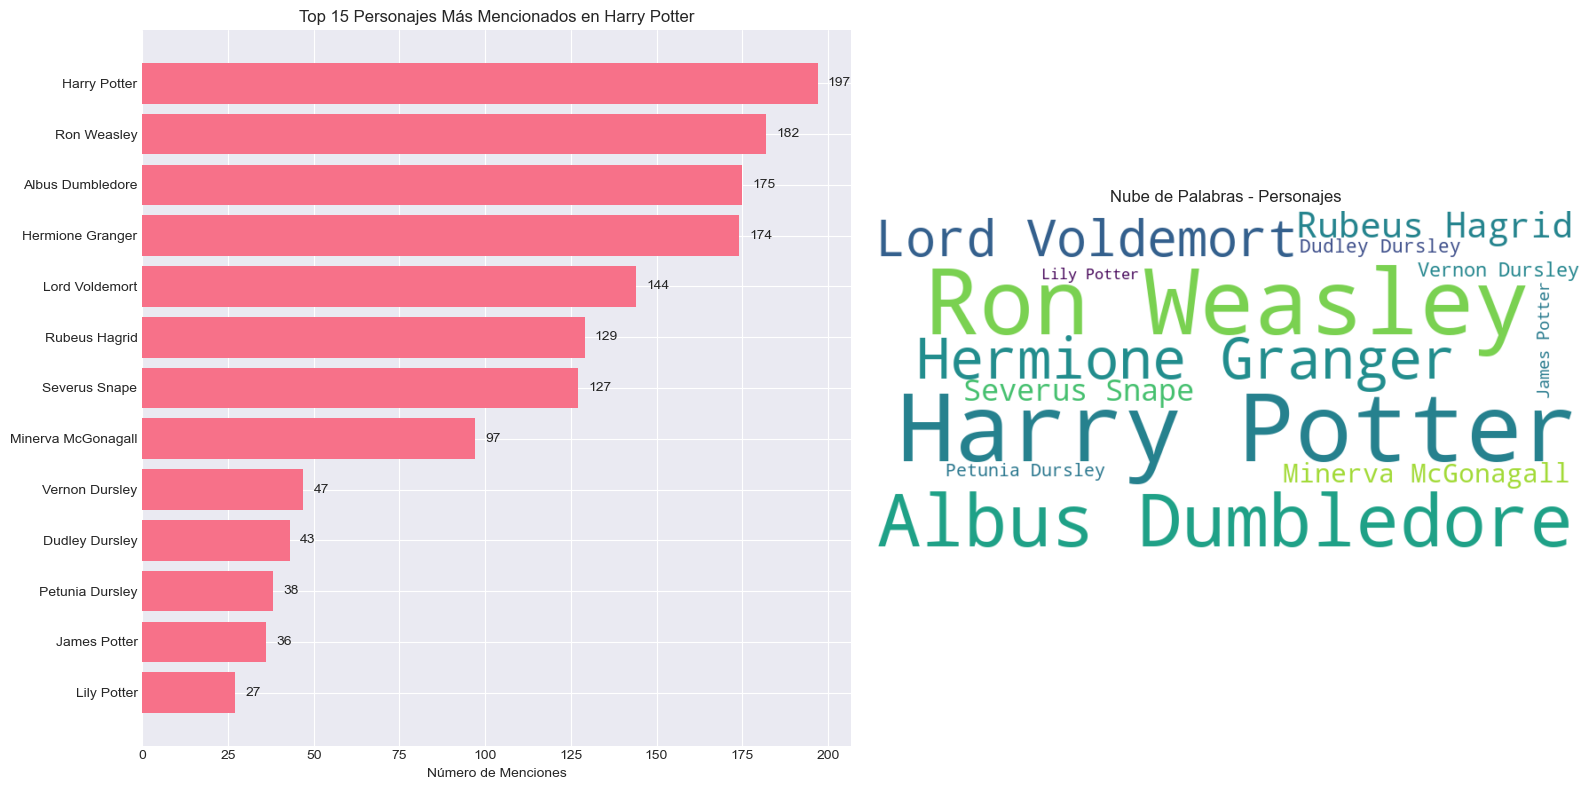


 - ANÁLISIS DE LUGARES MÁS VISITADOS 

Total de lugares : 21
Total de menciones: 800

Top 10 lugares más mencionados:
            Lugar  Menciones
         Hogwarts        168
Ministry Of Magic         85
       Great Hall         80
          Azkaban         80
        Hogsmeade         56
 Gryffindor Tower         50
     Privet Drive         41
 Forbidden Forest         36
       The Burrow         32
        Gringotts         31


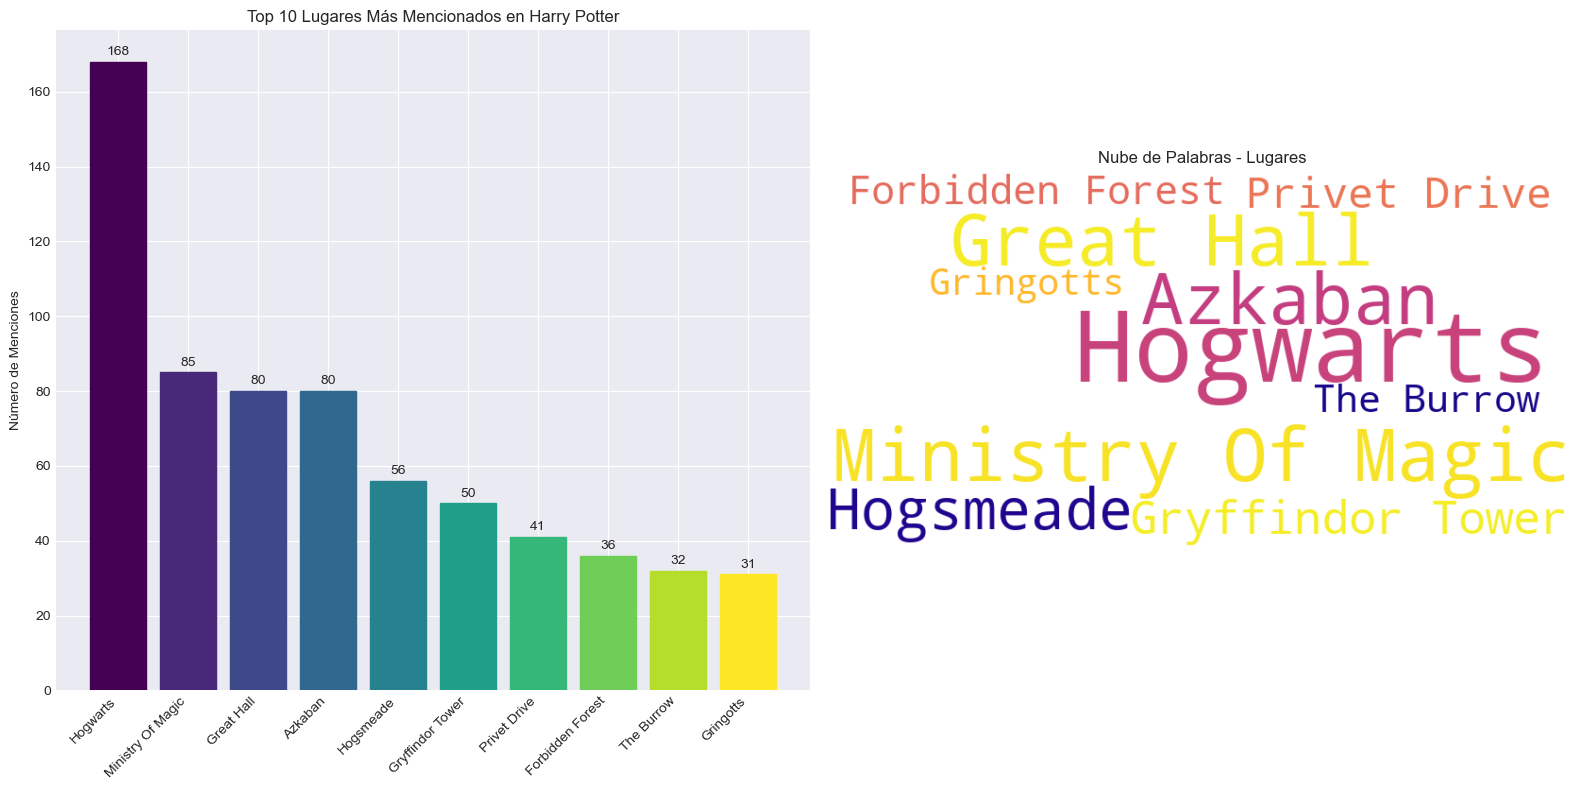


=== EVOLUCIÓN DE HARRY POTTER A TRAVÉS DE LA SAGA ===

Total de menciones en la saga: 197
Promedio por libro: 28.1
Libro con más menciones: Libro the Order of the Phoenix - 38 menciones

Detalle por libro:
 the Sorcerers Stone: 17 menciones
 the Chamber of Secrets: 17 menciones
 the Prisoner of Azkaban: 22 menciones
 the Goblet of Fire: 37 menciones
 the Order of the Phoenix: 38 menciones
 the Half-Blood Prince: 30 menciones
 the Deathly Hallows: 36 menciones


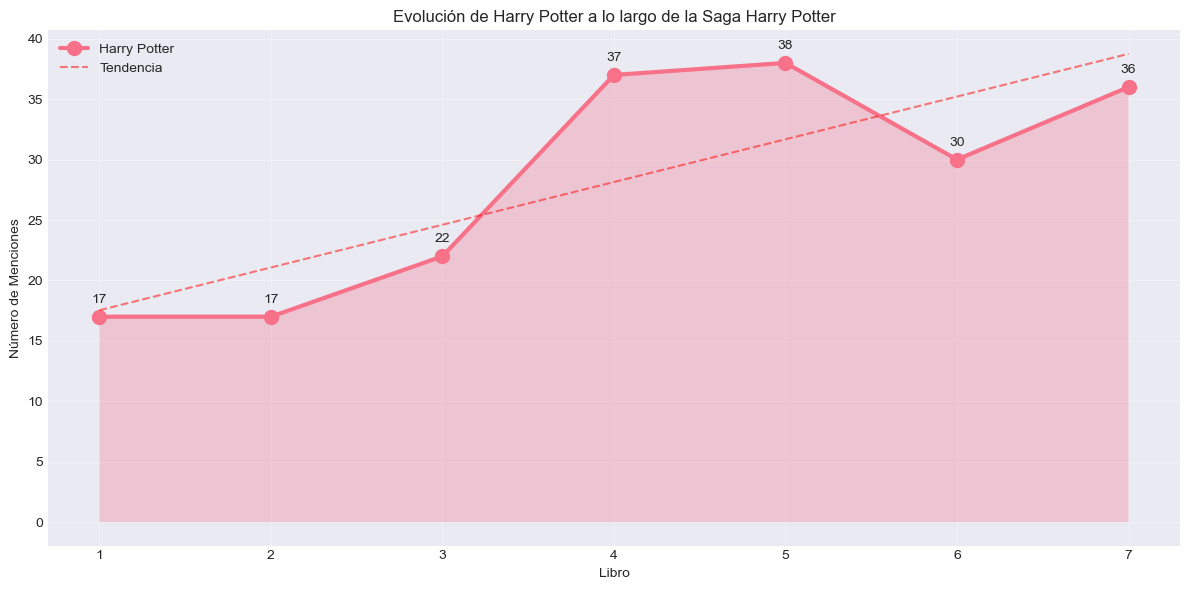


=== EVOLUCIÓN DE HERMIONE GRANGER A TRAVÉS DE LA SAGA ===

Total de menciones en la saga: 174
Promedio por libro: 24.9
Libro con más menciones: Libro the Order of the Phoenix - 35 menciones

Detalle por libro:
 the Sorcerers Stone: 12 menciones
 the Chamber of Secrets: 16 menciones
 the Prisoner of Azkaban: 22 menciones
 the Goblet of Fire: 30 menciones
 the Order of the Phoenix: 35 menciones
 the Half-Blood Prince: 25 menciones
 the Deathly Hallows: 34 menciones


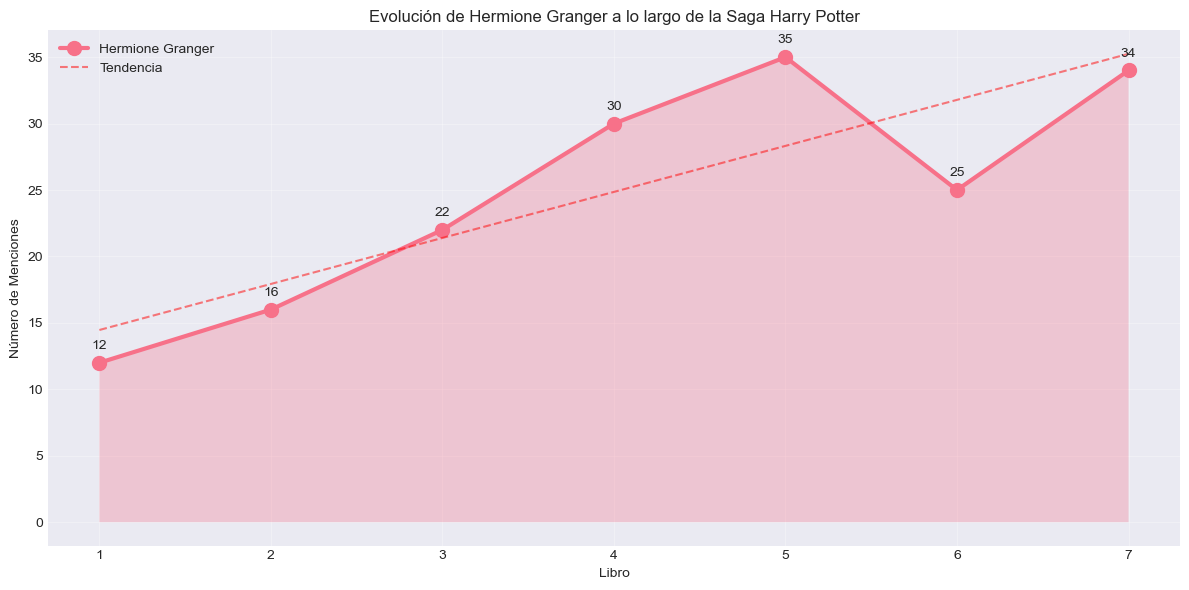


=== EVOLUCIÓN DE RON WEASLEY A TRAVÉS DE LA SAGA ===

Total de menciones en la saga: 182
Promedio por libro: 26.0
Libro con más menciones: Libro the Order of the Phoenix - 38 menciones

Detalle por libro:
 the Sorcerers Stone: 13 menciones
 the Chamber of Secrets: 17 menciones
 the Prisoner of Azkaban: 22 menciones
 the Goblet of Fire: 32 menciones
 the Order of the Phoenix: 38 menciones
 the Half-Blood Prince: 27 menciones
 the Deathly Hallows: 33 menciones


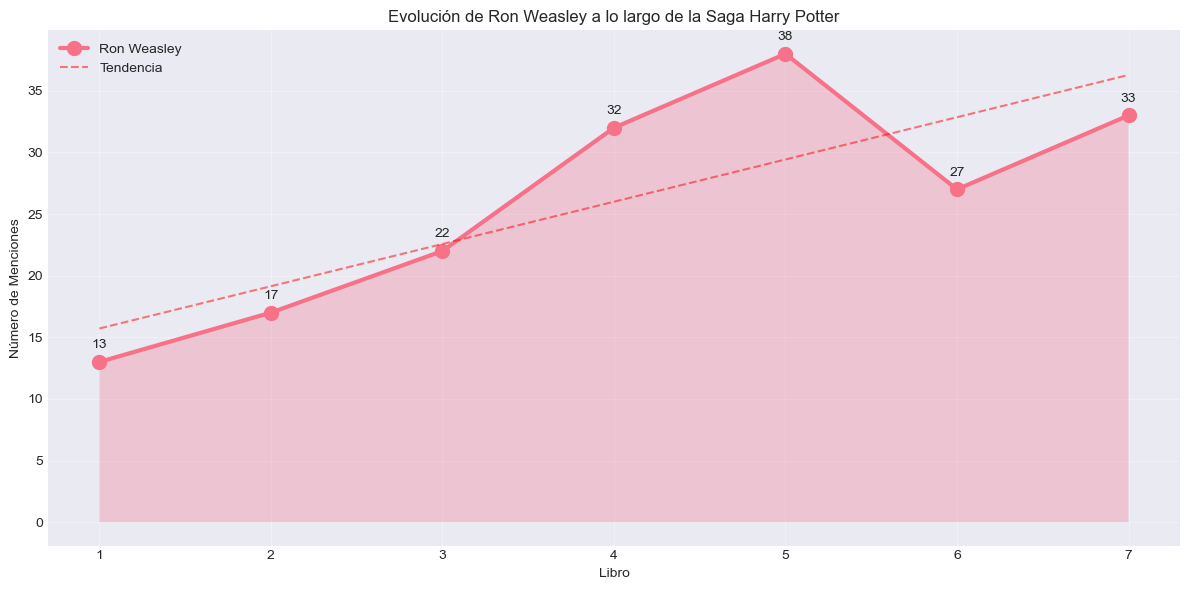


=== EVOLUCIÓN DE LORD VOLDEMORT A TRAVÉS DE LA SAGA ===

Total de menciones en la saga: 144
Promedio por libro: 20.6
Libro con más menciones: Libro the Deathly Hallows - 34 menciones

Detalle por libro:
 the Sorcerers Stone: 7 menciones
 the Chamber of Secrets: 9 menciones
 the Prisoner of Azkaban: 14 menciones
 the Goblet of Fire: 24 menciones
 the Order of the Phoenix: 30 menciones
 the Half-Blood Prince: 26 menciones
 the Deathly Hallows: 34 menciones


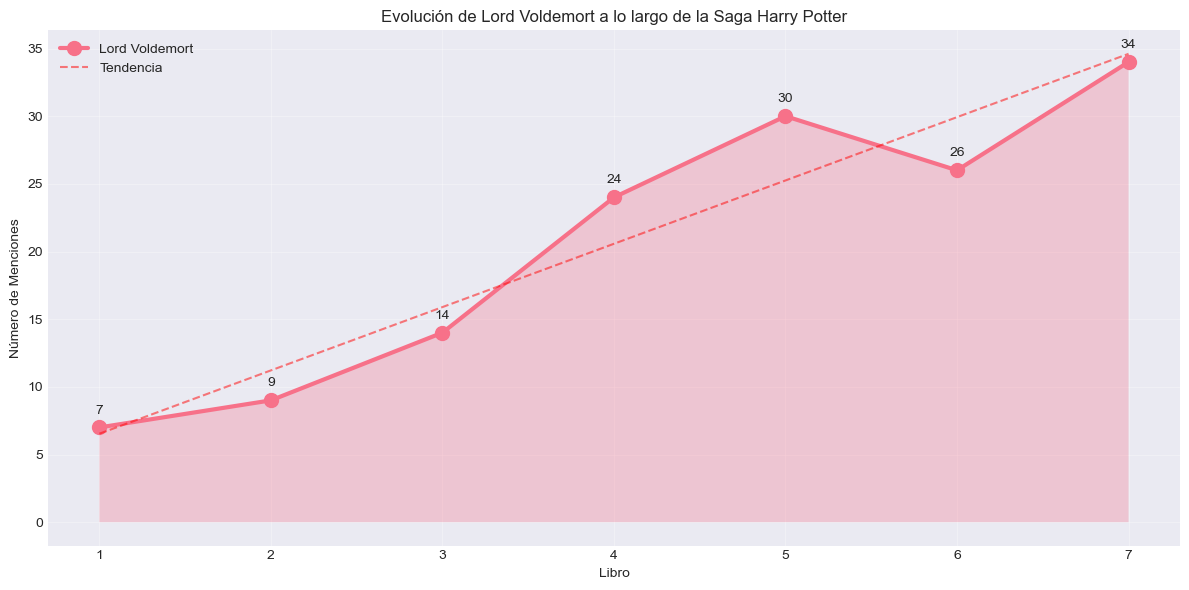


=== EVOLUCIÓN DE ALBUS DUMBLEDORE A TRAVÉS DE LA SAGA ===

Total de menciones en la saga: 175
Promedio por libro: 25.0
Libro con más menciones: Libro the Order of the Phoenix - 36 menciones

Detalle por libro:
 the Sorcerers Stone: 14 menciones
 the Chamber of Secrets: 15 menciones
 the Prisoner of Azkaban: 16 menciones
 the Goblet of Fire: 29 menciones
 the Order of the Phoenix: 36 menciones
 the Half-Blood Prince: 30 menciones
 the Deathly Hallows: 35 menciones


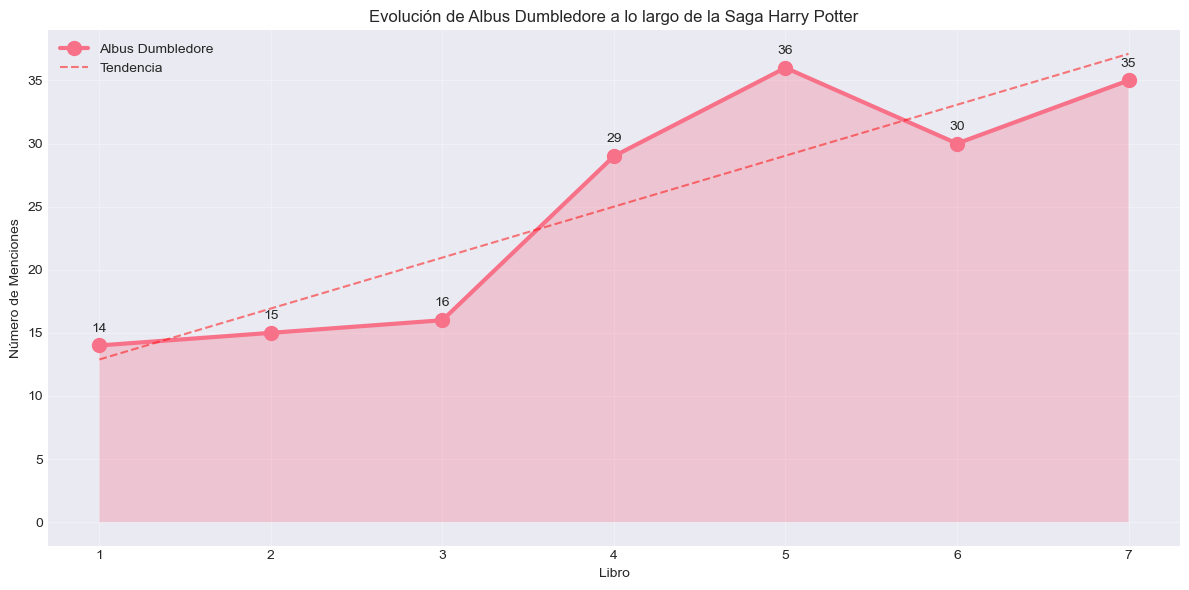


=== COMPARACIÓN DE EVOLUCIÓN: Harry Potter, Lord Voldemort, Albus Dumbledore, Severus Snape ===



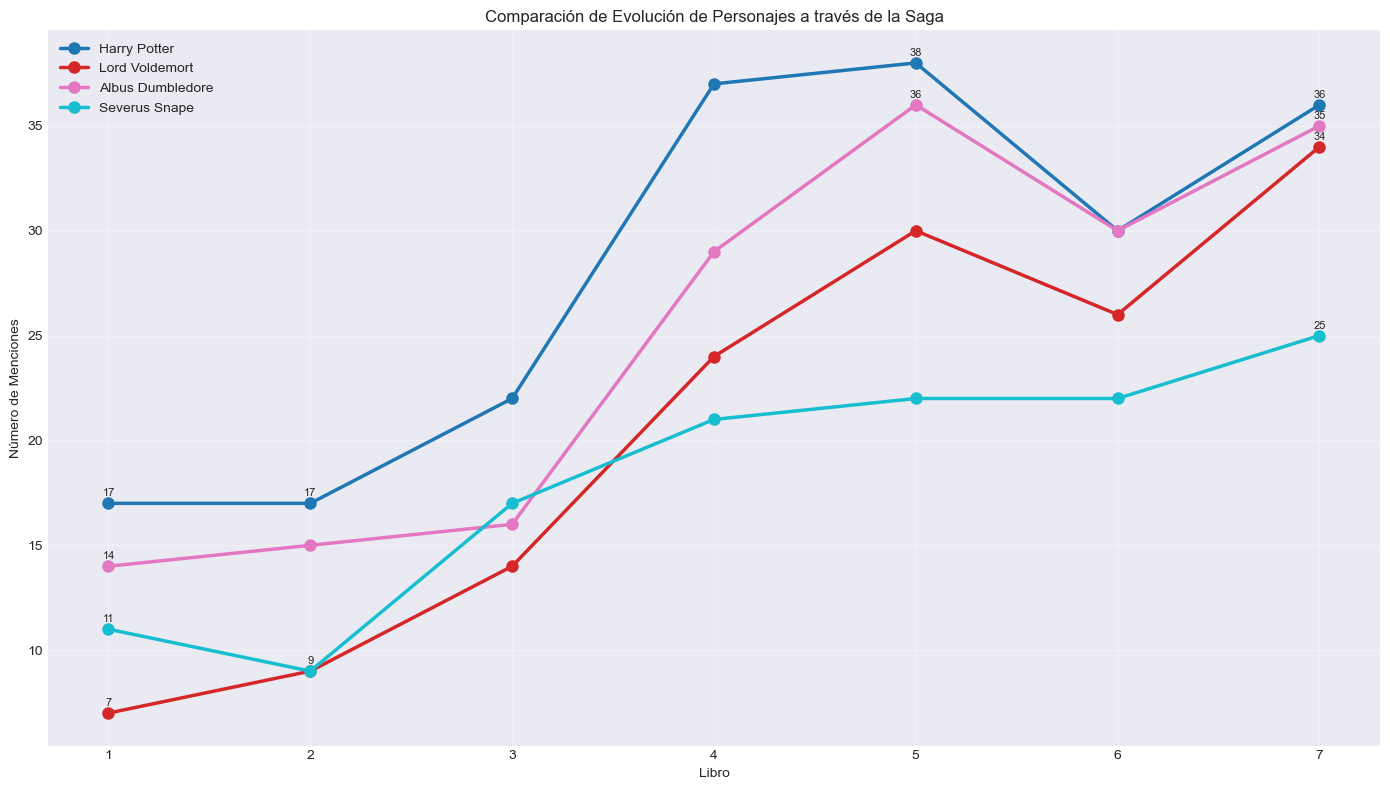


=== ANÁLISIS DE OBJETOS MÁGICOS Y HECHIZOS ===



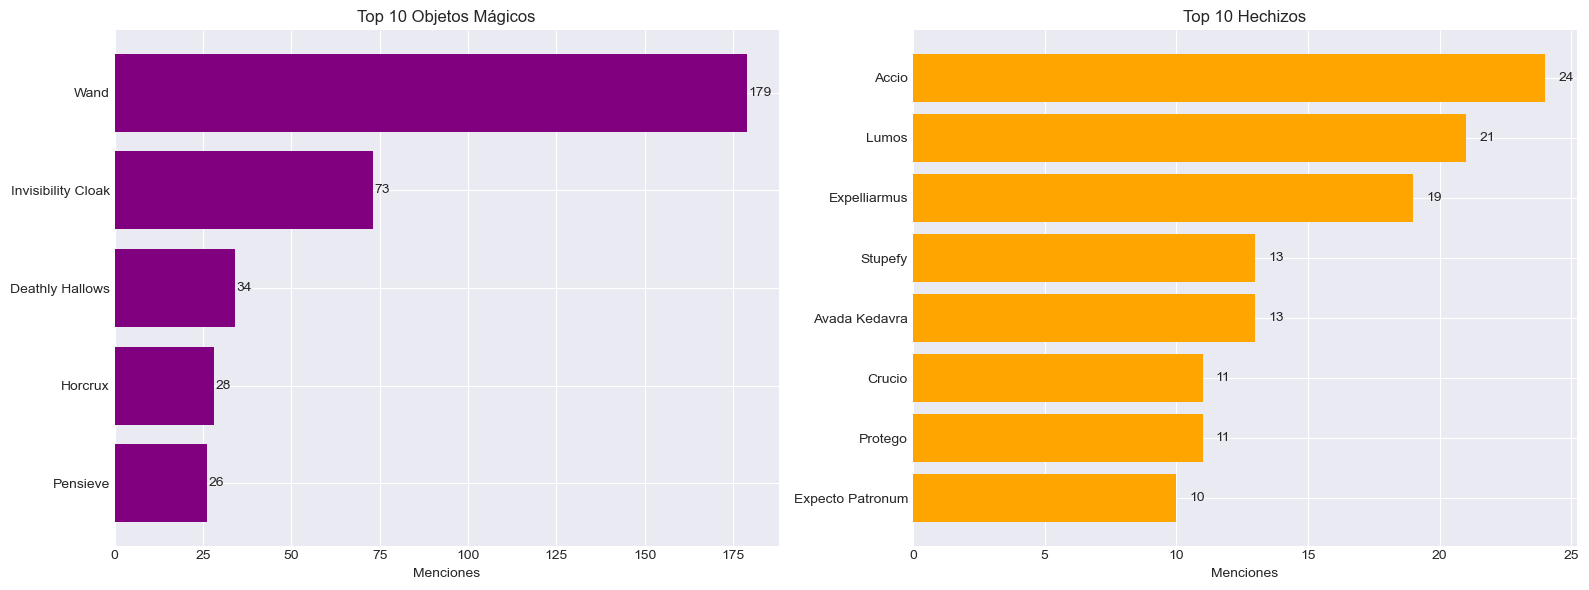

In [ ]:
eda = HarryPotterEDA(df_libros)
eda.generar_reporte_completo()


In [ ]:
class HarryPotterExtendedAnalysis:
    
    def __init__(self):
        # Diccionarios de casas de Hogwarts
        self.casas_hogwarts = {
            'gryffindor': ['gryffindor', 'harry potter', 'hermione granger', 'ron weasley', 
                          'neville longbottom', 'ginny weasley'],
            'slytherin': ['slytherin', 'draco malfoy', 'lord voldemort', 'severus snape',
                         'lucius malfoy'],
            'hufflepuff': ['hufflepuff', 'cedric diggory'],
            'ravenclaw': ['ravenclaw', 'luna lovegood', 'cho chang']
        }
        
        # Valores por casa
        self.valores_casas = {
            'gryffindor': ['brave', 'courage', 'daring', 'bold'],
            'slytherin': ['cunning', 'ambitious', 'clever', 'power'],
            'hufflepuff': ['loyal', 'patient', 'fair', 'kind'],
            'ravenclaw': ['wise', 'intelligent', 'clever', 'creative']
        }
        
        # Temas narrativos
        self.temas = {
            'muerte': ['death', 'died', 'killed', 'dead'],
            'amistad': ['friend', 'friendship', 'together'],
            'miedo': ['fear', 'afraid', 'scared'],
            'amor': ['love', 'loved', 'heart']
        }
    
    def analizar_casas_hogwarts(self, df_entidades):
        """Analiza menciones de casas y sus valores asociados"""
        print("=== ANÁLISIS DE CASAS DE HOGWARTS ===\n")
        
        conteos_casas = Counter()
        valores_por_casa = defaultdict(Counter)
        
        for _, row in df_entidades.iterrows():
            texto = str(row.get('texto', '')).lower()
            
            # Contar menciones por casa
            for casa, miembros in self.casas_hogwarts.items():
                menciones = sum(texto.count(miembro.lower()) for miembro in miembros)
                conteos_casas[casa] += menciones
                
                # Contar valores asociados
                if menciones > 0:
                    for valor in self.valores_casas[casa]:
                        valores_por_casa[casa][valor] += texto.count(valor)
        
        # Mostrar resultados
        print("MENCIONES POR CASA:")
        for casa, count in conteos_casas.most_common():
            print(f"{casa.capitalize()}: {count}")
        
        print("\nVALORES MÁS MENCIONADOS:")
        for casa, valores in valores_por_casa.items():
            if valores:
                top = valores.most_common(2)
                print(f"{casa.capitalize()}: {', '.join([f'{v}({c})' for v, c in top])}")
        
        self._visualizar_casas(conteos_casas, valores_por_casa)
        return conteos_casas, valores_por_casa

    
    
    def analizar_arcos_narrativos(self, df_entidades):
        """Analiza evolución de temas por libro"""
        print("\n=== ARCOS NARRATIVOS ===\n")
        
        temas_por_libro = defaultdict(lambda: defaultdict(int))
        
        for _, row in df_entidades.iterrows():
            libro = row['libro']
            texto = str(row.get('texto', '')).lower()
            
            for tema, palabras in self.temas.items():
                count = sum(texto.count(palabra) for palabra in palabras)
                temas_por_libro[libro][tema] += count
        
        # Convertir a DataFrame para análisis
        df_temas = []
        for libro, temas in temas_por_libro.items():
            for tema, count in temas.items():
                df_temas.append({'libro': libro, 'tema': tema, 'menciones': count})
        
        df_temas = pd.DataFrame(df_temas)
        
        # Mostrar evolución
        print("EVOLUCIÓN DE TEMAS:")
        for tema in self.temas.keys():
            tema_data = df_temas[df_temas['tema'] == tema].sort_values('libro')
            if not tema_data.empty:
                total = tema_data['menciones'].sum()
                print(f"{tema.capitalize()}: {total} menciones totales")
        
        self._visualizar_arcos(df_temas)
        return df_temas
    
        
    def _visualizar_casas(self, conteos_casas, valores_por_casa):
        """Visualiza análisis de casas"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Menciones por casa
        casas = list(conteos_casas.keys())
        menciones = list(conteos_casas.values())
        colors = ['#740001', '#1a472a', '#ecb939', '#0e1a40']
        
        ax1.bar(casas, menciones, color=colors[:len(casas)])
        ax1.set_title('Menciones por Casa')
        ax1.set_ylabel('Menciones')
        
        # Valores por casa (top 3 por casa)
        casa_valores = []
        valores_nombres = []
        valores_counts = []
        
        for casa, valores in valores_por_casa.items():
            if valores:
                top_valores = valores.most_common(3)
                for valor, count in top_valores:
                    casa_valores.append(casa)
                    valores_nombres.append(valor)
                    valores_counts.append(count)
        
        if casa_valores:
            df_valores = pd.DataFrame({
                'casa': casa_valores,
                'valor': valores_nombres,
                'count': valores_counts
            })
            
            pivot = df_valores.pivot_table(values='count', index='casa', 
                                         columns='valor', fill_value=0)
            sns.heatmap(pivot, annot=True, fmt='.0f', ax=ax2, cmap='YlOrRd')
            ax2.set_title('Valores por Casa')
        
        plt.tight_layout()
        plt.show()
    
    def _visualizar_arcos(self, df_temas):
        """Visualiza evolución de temas"""
        plt.figure(figsize=(12, 6))
        
        for tema in df_temas['tema'].unique():
            data = df_temas[df_temas['tema'] == tema].sort_values('libro')
            if not data.empty:
                libros_num = [int(re.match(r'\d+', libro).group()) for libro in data['libro']]
                plt.plot(libros_num, data['menciones'], marker='o', 
                        label=tema.capitalize(), linewidth=2)
        
        plt.title('Evolución de Temas por Libro')
        plt.xlabel('Libro')
        plt.ylabel('Menciones')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    

In [ ]:
def extender_analisis_original(eda_instance):

    extendido = HarryPotterExtendedAnalysis()
    
    # Análisis de casas
    casas_info = extendido.analizar_casas_hogwarts(eda_instance.df_entidades)
    
    # Arcos narrativos
    arcos_info = extendido.analizar_arcos_narrativos(eda_instance.df_entidades)
    
    return {
        'casas': casas_info,
        'arcos': arcos_info
    }

=== ANÁLISIS DE CASAS DE HOGWARTS ===

MENCIONES POR CASA:
Gryffindor: 1355
Slytherin: 842
Ravenclaw: 220
Hufflepuff: 195

VALORES MÁS MENCIONADOS:
Gryffindor: brave(89), courage(50)
Slytherin: power(305), clever(58)
Hufflepuff: kind(139), fair(62)
Ravenclaw: wise(53), clever(24)


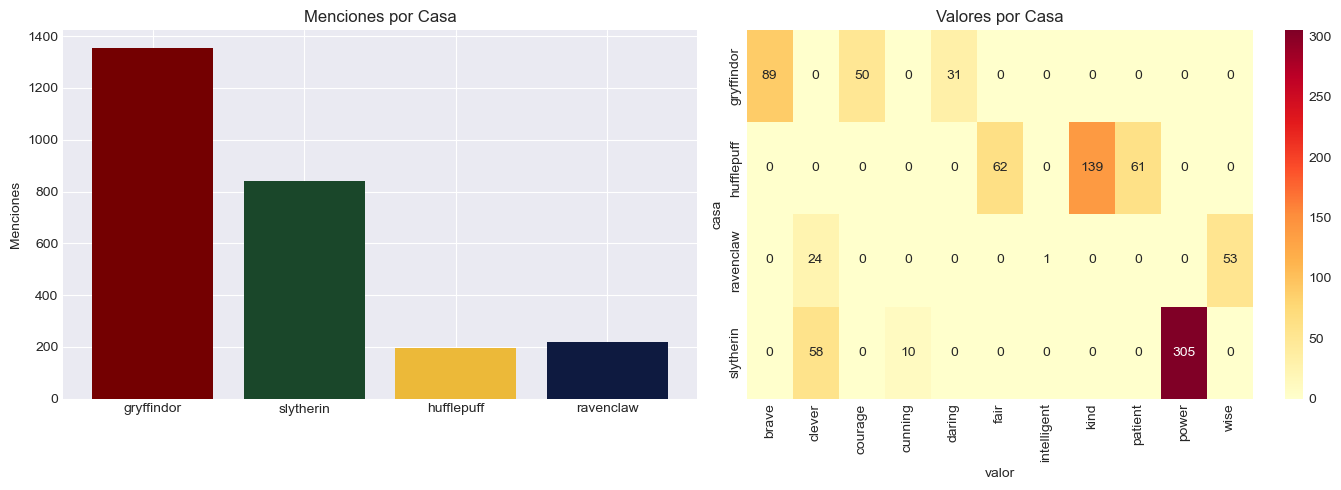


=== ARCOS NARRATIVOS ===

EVOLUCIÓN DE TEMAS:
Muerte: 1766 menciones totales
Amistad: 953 menciones totales
Miedo: 470 menciones totales
Amor: 780 menciones totales


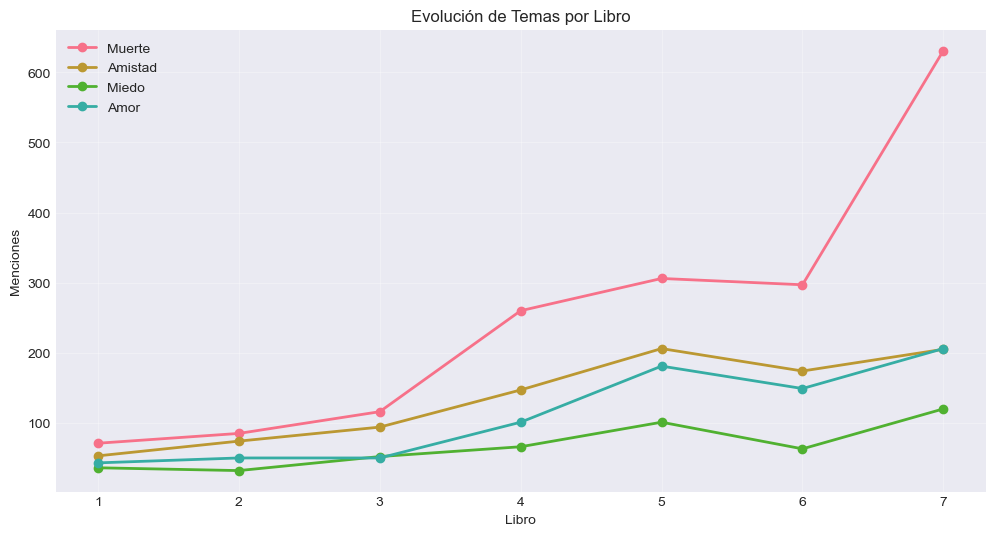

In [ ]:
eda = HarryPotterEDA(df_libros)

resultados = extender_analisis_original(eda)

### Modelo prueba


In [ ]:
def extraer_entidades_spacy_puro(doc):
    """Extrae entidades usando únicamente spaCy sin normalización"""
    entidades_spacy = set()
    
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'PER']:
            entidades_spacy.add((ent.text.lower().strip(), 'PERSONAJE'))
        elif ent.label_ in ['LOC', 'GPE']:
            entidades_spacy.add((ent.text.lower().strip(), 'LUGAR'))
        elif ent.label_ in ['ORG']:
            entidades_spacy.add((ent.text.lower().strip(), 'ORGANIZACION'))
        elif ent.label_ in ['PRODUCT', 'WORK_OF_ART']:
            entidades_spacy.add((ent.text.lower().strip(), 'OBJETO_MAGICO'))
    
    return entidades_spacy
